In [1]:
import pickle
import numpy as np

In [2]:
with open('../UPDATED_NLP_COURSE/06-Deep-Learning/train_qa.txt','rb') as f:
    train_data=pickle.load(f)

In [3]:
with open('../UPDATED_NLP_COURSE/06-Deep-Learning/test_qa.txt','rb') as f:
    test_data=pickle.load(f)

In [4]:
type(train_data)

list

In [5]:
type(test_data)

list

In [6]:
len(train_data)

10000

In [7]:
len(test_data)

1000

In [8]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [9]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [10]:
' '.join(train_data[0][2])

'n o'

In [11]:
all_data=train_data+test_data

In [12]:
len(all_data)

11000

In [13]:
vocab=set()
for story,question,answer in all_data:
    vocab=vocab.union(set(story))
    vocab=vocab.union(set(question))

In [14]:
#adding 2 possible answers
vocab.add('yes')
vocab.add('no')

In [15]:
#total len +1 since we need a placeholder for keras paddin
vocab_len= len(vocab)+1

In [16]:
vocab_len

38

In [17]:
#longest story
all_story_len=[len(data[0]) for data in all_data]

In [18]:
#we need max story len for padding sequences
max_story_len=max(all_story_len)

In [19]:
#same for the questions 
max_question_len=max([len(data[1]) for data in all_data])

In [20]:
max_question_len

6

In [21]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [22]:
tokenizer=Tokenizer(filters=[])

In [23]:
tokenizer.fit_on_texts(vocab)

In [24]:
tokenizer.word_index

{'up': 1,
 'dropped': 2,
 'football': 3,
 'milk': 4,
 'there': 5,
 'no': 6,
 'hallway': 7,
 'grabbed': 8,
 'apple': 9,
 'office': 10,
 'is': 11,
 '.': 12,
 'mary': 13,
 'got': 14,
 'john': 15,
 'down': 16,
 'went': 17,
 'sandra': 18,
 'bathroom': 19,
 'travelled': 20,
 'picked': 21,
 'took': 22,
 'the': 23,
 'yes': 24,
 'discarded': 25,
 'garden': 26,
 'back': 27,
 'in': 28,
 '?': 29,
 'journeyed': 30,
 'to': 31,
 'put': 32,
 'moved': 33,
 'kitchen': 34,
 'left': 35,
 'daniel': 36,
 'bedroom': 37}

In [25]:
train_story_text=[]
train_question_text=[]
train_answer=[]

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)
    train_answer.append(answer)

In [26]:
#train_story_text

In [27]:
#coverting sentances/stories to index seq
train_story_seq=tokenizer.texts_to_sequences(train_story_text)

In [28]:
def vectorize_stories(data,word_index=tokenizer.word_index,max_story_len=max_story_len,max_question_len=max_question_len):
    #stories
    X=[]
    #questions
    Xq=[]
    #answers
    Y=[]
    
    for story,question,answer in data:
        #for each story
        x=[word_index[word.lower()] for word in story]
        xq=[word_index[word.lower()] for word in question]
        
        y=np.zeros(len(word_index)+1)
        y[word_index[answer]]=1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
        
    return (pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_question_len),pad_sequences(Y))

In [29]:
inputs_train,questions_train,answers_train =vectorize_stories(train_data)

In [30]:
inputs_test,questions_test,answers_test =vectorize_stories(test_data)

In [31]:
tokenizer.word_index['yes']

24

In [32]:
tokenizer.word_index['no']

6

In [33]:
sum(answers_train)

array([   0,    0,    0,    0,    0,    0, 4988,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 5012,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])

In [35]:
from pickle import load,dump
dump(tokenizer,open('Q&A bot','wb'))

In [44]:
#building the neural network from here
from tensorflow.keras.models import Sequential,Model
from keras.layers.embeddings import Embedding
from keras.layers import Input,Activation,Dense,Permute,Dropout,add,dot,concatenate,LSTM

In [45]:
#placeholder input(shape(max_story_len,batch_size))   
#((we leave batch size empty so we can define and modify it later ))
input_sequence=Input((max_story_len,))
question=Input((max_question_len,))


In [46]:
#input encoder m
input_encoder_m=Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_len,output_dim=64))
input_encoder_m.add(Dropout(0.3))

#output
#(samples,story_maxlen,embedding_dim)

In [47]:
#input encoder c
input_encoder_c=Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_len,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

#output
#(samples,story_maxlen,max_question_len)

In [48]:
#question encoder 
question_encoder=Sequential()
question_encoder.add(Embedding(input_dim=vocab_len,output_dim=64,input_length=max_question_len))
question_encoder.add(Dropout(0.3))

#output
#(samples,question_maxlen,embedding_dim)

In [49]:
#encoded<--- encoder(input)
input_encoded_m=input_encoder_m(input_sequence)
input_encoded_c=input_encoder_c(input_sequence)
question_encoded=question_encoder(question)

In [50]:
match= dot([input_encoded_m,question_encoded],axes=(2,2))
match= Activation('softmax')(match)

In [51]:
response=add([match,input_encoded_c])
response =Permute((2,1))(response)

In [52]:
answer= concatenate([response,question_encoded])

In [53]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [54]:
answer=LSTM(32)(answer)
answer=Dropout(0.5)(answer)
answer=Dense(vocab_len)(answer)

In [55]:
answer =Activation('softmax')(answer)

In [57]:
model=Model([input_sequence,question],answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [59]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                            

In [61]:
history=model.fit([inputs_train,questions_train],answers_train,batch_size=32,epochs=100,validation_data=([inputs_test,questions_test],answers_test))

Epoch 1/100
313/313 [==============================] - 5s 10ms/step - loss: 0.9741 - accuracy: 0.4966 - val_loss: 0.6962 - val_accuracy: 0.5030
Epoch 2/100
313/313 [==============================] - 3s 11ms/step - loss: 0.7088 - accuracy: 0.4997 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 3/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6966 - accuracy: 0.4929 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 4/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6948 - accuracy: 0.5076 - val_loss: 0.6935 - val_accuracy: 0.4970
Epoch 5/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6950 - accuracy: 0.4936 - val_loss: 0.6952 - val_accuracy: 0.5030
Epoch 6/100
313/313 [==============================] - 3s 11ms/step - loss: 0.6946 - accuracy: 0.4990 - val_loss: 0.6964 - val_accuracy: 0.4970
Epoch 7/100
313/313 [==============================] - 4s 11ms/step - loss: 0.6949 - accuracy: 0.4941 - val_loss: 0.6933 - val_accuracy:

In [62]:
model.save('Q&A-bot.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


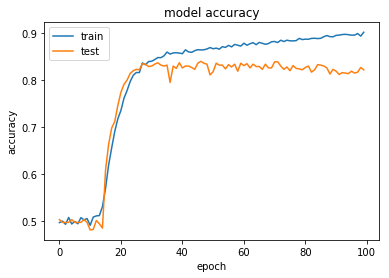

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
#you can predict on new stories and question using the prodoct function and same format
#NOTE: you are limited to the words in the vocab of the model
pred_results=model.predict(([inputs_test,questions_test]))

In [67]:
pred_results.shape


(1000, 38)

In [73]:
 ' '.join(test_data[0][0])

'Mary got the milk there . John moved to the bedroom .'

In [74]:
 ' '.join(test_data[0][1])

'Is John in the kitchen ?'

In [75]:
 ' '.join(test_data[0][2])

'n o'

In [68]:
max_probability=np.argmax(pred_results[0])

In [71]:
for key,val in tokenizer.word_index.items():
    if val==max_probability:
        k=key
        

In [72]:
k

'no'

In [76]:
pred_results[0][max_probability]

0.9999858

In [77]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [78]:
my_question = "Is the football in the garden ?"
my_question.split()


['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [79]:
mydata = [(my_story.split(),my_question.split(),'yes')]
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [80]:
pred_results = model.predict(([ my_story, my_ques]))

In [81]:
max_probability=np.argmax(pred_results[0])

for key,val in tokenizer.word_index.items():
    if val==max_probability:
        k=key
        

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][max_probability])

Predicted answer is:  yes
Probability of certainty was:  0.99863905
